# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Final Project Milestone 2 - EDA

**Harvard University**<br/>
**Spring 2020**<br/>
**Group 32**: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## <a id='0'>Content</a>

- <a href='#1'>1. Introduction</a> 
- <a href='#2'>2. Data</a>
- <a href='#3'>3. Exploratory Data Analysis</a>
- <a href='#4'>4. Conclusion</a>  

## <a id='1'>1. Introduction</a>


In this project, we will read case law, and generate automatic summarizations of the cases. Headnotes are brief case summary statements often generated by commercial third parties. Therefore, they are often under copyright protection, and are not always available to public or are subject to strict usage restrictions. Our goal is to construct a model to reconstruct these headnotes for a variety of cases using historical court cases as a training set. We will use data from [Caselaw Access Project](https://case.law/) by Harvard Law School. 

## <a id='2'>2. Data</a>

In the Caselaw Access Project, there are four states (Arkansas, Illinois, New Mexico, New Carolina) with available bulk data. The data sets are available both in text format and xml format, but we will use the text format in the following analysis. In the datasets, each case is represented by a JSON object, which includes various information about the case. For example,

- `head_matter` represents all text printed in the volume before the text prepared by judges
- `opinions` contains a dictionary for each opinion in the case

There are following number of cases for each state:
- Arkansas: 59,734
- Illinois: 183,146
- New Mexico: 18,338
- New Carolina: 97,600

## <a id='3'>3. Exploratory Data Analysis</a>
To perform exploratory data analysis, we compute word-length of headnotes and opinions in each case.

In [2]:
# libraries
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# defining a fucnction to remove \n and HTML tags
def text_cleaner(text):
    text_divided = text.splitlines()
    text_divided_clean = " ".join(text_divided)
    return text_divided_clean

In [4]:
# The file size for some states are too large to open into memory
# This function loads individual cases into memory, parses headnotes and 
# opinions, cleans the text, tokenizes the text, and returns counts of tokens
# for each case.

tokenizer = RegexpTokenizer('\s+', gaps=True)

def get_counts(state):
    cases = []
    with lzma.open("../" + state + '-text/data/data.jsonl.xz', 'r') as jsonl_file:
        for case in jsonl_file:
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = text_cleaner(c['casebody']['data']['head_matter'])
            headnotes_tokenized = tokenizer.tokenize(headnotes)
            num_headnotes = len(headnotes_tokenized)

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                num_opinions = 0
            else:
                opinions = text_cleaner(opinions[0]['text'])
                opinions_tokenized = tokenizer.tokenize(opinions)
                num_opinions = len(opinions_tokenized)
            cases.append({'date':date, 'num_headnotes':num_headnotes, 'num_opinions':num_opinions})
        return pd.DataFrame(cases)

In [5]:
%%time

states = ['Arkansas', 'Illinois', 'New Mexico', 'North Carolina']
counts_ar = get_counts(states[0])
counts_il = get_counts(states[1])
counts_nm = get_counts(states[2])
counts_nc = get_counts(states[3])

CPU times: user 4min 26s, sys: 1.15 s, total: 4min 28s
Wall time: 4min 28s


In [6]:
counts_ar.to_csv('csv/counts_ar.csv', index=False)
counts_il.to_csv('csv/counts_il.csv', index=False)
counts_nm.to_csv('csv/counts_nm.csv', index=False)
counts_nc.to_csv('csv/counts_nc.csv', index=False)

In [7]:
print("number of cases, Arakansas", counts_ar.shape[0])
print("number of cases, Illinois", counts_il.shape[0])
print("number of cases, New Mexico", counts_nm.shape[0])
print("number of cases, New Carolina", counts_nc.shape[0])

number of cases, Arakansas 59735
number of cases, Illinois 183146
number of cases, New Mexico 18338
number of cases, New Carolina 97600


In [8]:
# Groups cases by the year of decision and returns the average number of tokens for headnotes and opinions.
def get_mean(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df_year = df.groupby('year').agg('mean')
    return df_year

In [9]:
counts_nc['date'] = pd.to_datetime(counts_nc['date'], errors='coerce')

In [10]:
year_ar = get_mean(counts_ar)
year_il = get_mean(counts_il)
year_nm = get_mean(counts_nm)
year_nc = get_mean(counts_nc)

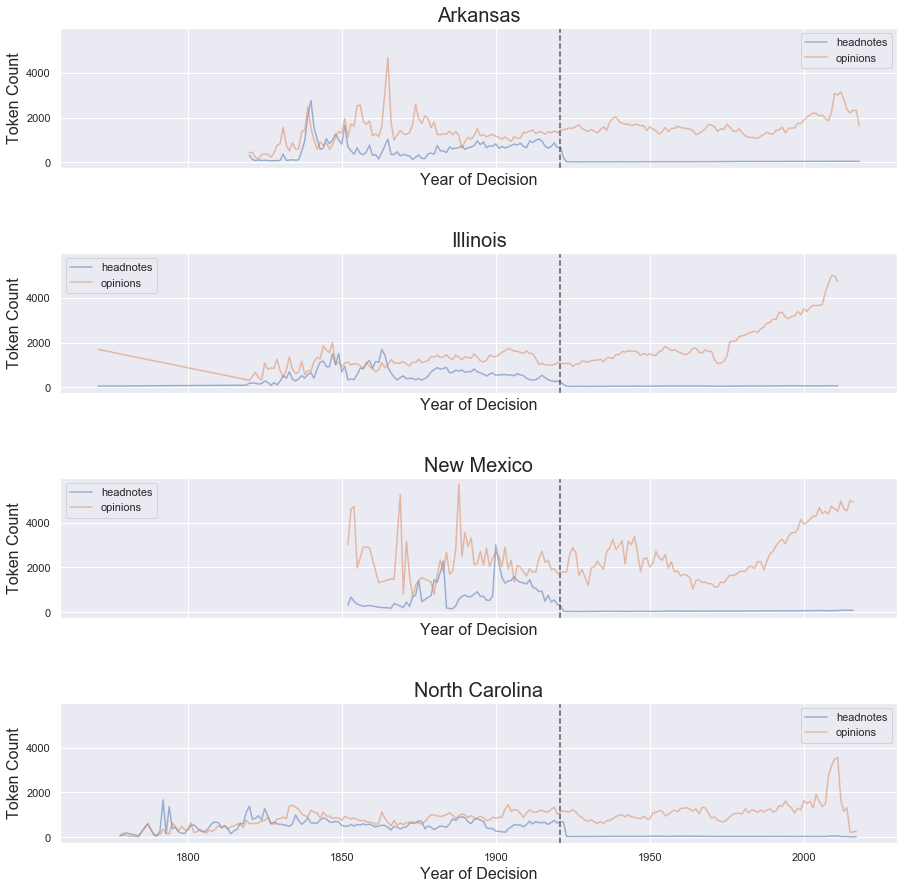

In [11]:
# Plots the average number of tokens for each state on a year by year basis. This plot
# shows how token counts vary over time as well as between states. Headnotes only 
# appear in case records up to 1920.

dfs = [counts_ar, counts_il, counts_nm, counts_nc]

f, ax = plt.subplots(4,1, figsize=[15,15], sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.6)

for c in range(len(states)):
    df = get_mean(dfs[c])
    ax[c].plot(df.num_headnotes, alpha=0.5, label='headnotes')
    ax[c].plot(df.num_opinions, alpha=0.5, label='opinions')
    ax[c].axvline(pd.Timestamp('1921').year, ls='--', color='k', alpha=0.7)
    ax[c].set_title(states[c], fontsize=20)
    ax[c].set_xlabel('Year of Decision', fontsize=16)
    ax[c].set_ylabel('Token Count', fontsize=16)
    ax[c].legend()

**Comments on Above Plots**

We see above that headnotes only appear in cases up to around 1920. We also see how the number of tokesn varies by year across the states. New Mexico and Arkansas have a much higher variability in the number of tokens across the years. New Mexico also generally has more tokens in opinions than the other states.

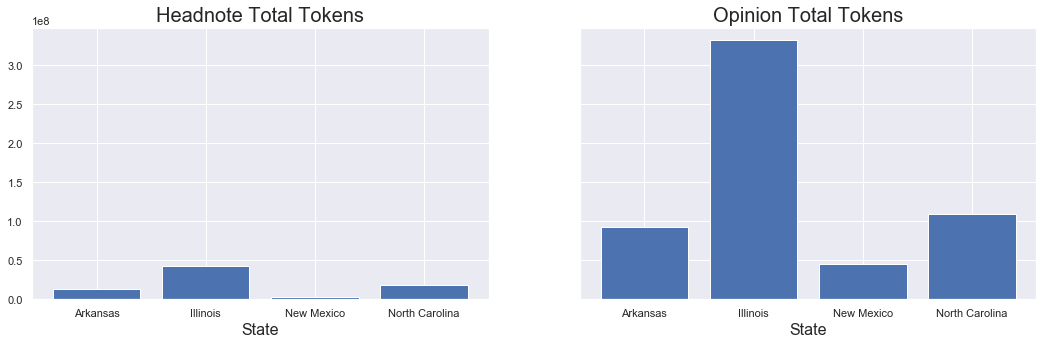

In [12]:
# The below functions and plots return summations of token counts for each state.

def headnote_total(df):
    return df['num_headnotes'].sum(axis=0)
headnote_totals = [headnote_total(df) for df in dfs]

def opinion_total(df):
    return df['num_opinions'].sum(axis=0)
opinion_totals = [opinion_total(df) for df in dfs]

f, ax = plt.subplots(1,2, figsize=[18,5], sharey=True)
ax[0].bar(states, headnote_totals)
ax[0].set_title('Headnote Total Tokens', fontsize=20)
ax[0].set_xlabel('State', fontsize=16)

ax[1].bar(states, opinion_totals)
ax[1].set_title('Opinion Total Tokens', fontsize=20)
ax[1].set_xlabel('State', fontsize=16)
plt.show()

**Comments on the Above Plots**

The entire dataset has many more tokens for opinions than headnotes, this is due in part to headnotes stopping around 1920. We also see above that we have more data coming from Illinois than the other three states.

/Users/akirasato/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


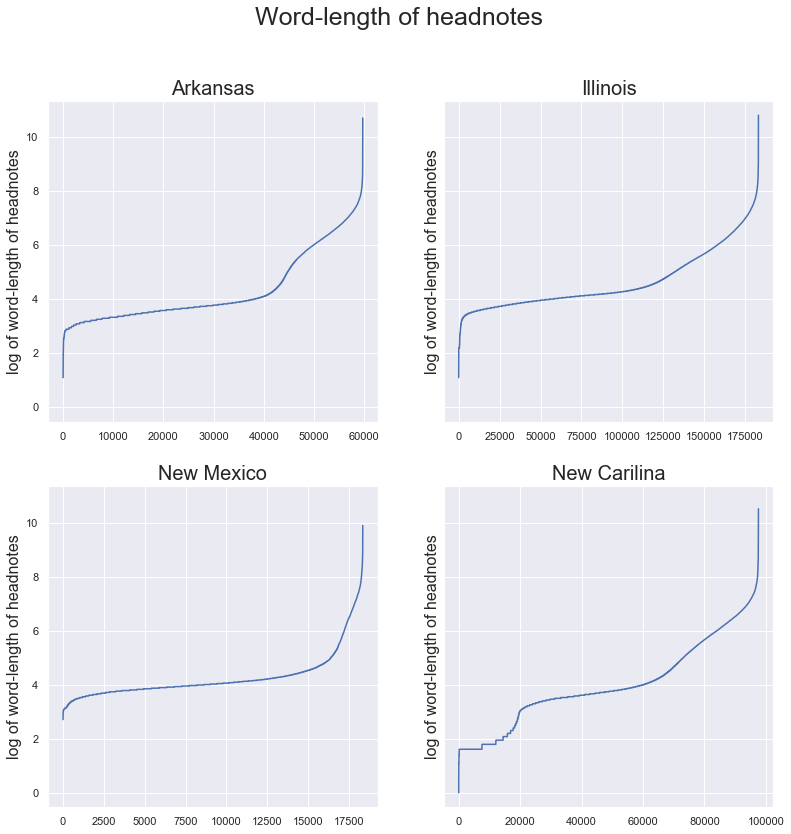

In [13]:
num_headnotes_ar = np.array(counts_ar.iloc[:,1])
num_headnotes_ar_sort = np.sort(num_headnotes_ar)

num_headnotes_il = np.array(counts_il.iloc[:,1])
num_headnotes_il_sort = np.sort(num_headnotes_il)

num_headnotes_nm = np.array(counts_nm.iloc[:,1])
num_headnotes_nm_sort = np.sort(num_headnotes_nm)

num_headnotes_nc = np.array(counts_nc.iloc[:,1])
num_headnotes_nc_sort = np.sort(num_headnotes_nc)

f, ax = plt.subplots(2,2, figsize=[13,13], sharey=True)
f.suptitle('Word-length of headnotes', fontsize=25)
ax[0, 0].plot(range(len(num_headnotes_ar_sort)),np.log(num_headnotes_ar_sort))
ax[0, 0].set_title('Arkansas', fontsize=20)
ax[0, 0].set_ylabel('log of word-length of headnotes', fontsize=16)

ax[0, 1].plot(range(len(num_headnotes_il_sort)),np.log(num_headnotes_il_sort))
ax[0, 1].set_title('Illinois', fontsize=20)
ax[0, 1].set_ylabel('log of word-length of headnotes', fontsize=16)

ax[1, 0].plot(range(len(num_headnotes_nm_sort)),np.log(num_headnotes_nm_sort))
ax[1, 0].set_title('New Mexico', fontsize=20)
ax[1, 0].set_ylabel('log of word-length of headnotes', fontsize=16)

ax[1, 1].plot(range(len(num_headnotes_nc_sort)),np.log(num_headnotes_nc_sort))
ax[1, 1].set_title('New Carilina', fontsize=20)
ax[1, 1].set_ylabel('log of word-length of headnotes', fontsize=16)
plt.show()

The third figure is a plot of log(`word-length of headnotes`). For example, we see "elbows" at x$\approx$7, x$\approx$400, x$\approx$42000, and x$\approx$60000 in the plot of Arkansas. We focus at the elbow between (sort) indices 30000 and 45000 in the following figure.

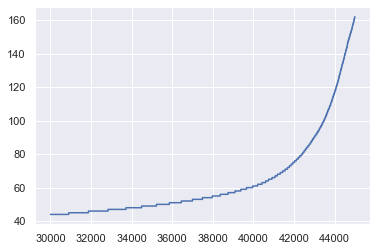

In [14]:
fig, ax = plt.subplots()
rnge_start = 30000
rnge_end = 45000
ax.plot(range(rnge_start, rnge_end),num_headnotes_ar_sort[rnge_start:rnge_end]);

Below, we are trying to find a general "boundary" with human-eye for when headmatters appears to become real summaries of opinion text, RATHER than just list of officials using Arakansas data.

In [15]:
hdnotes_df = pd.DataFrame(num_headnotes_ar, range(len(num_headnotes_ar)))
hdnotes_sort = hdnotes_df.sort_values(by=[0])
short_hds_lst = hdnotes_sort.loc[((hdnotes_sort[0]<573) & (hdnotes_sort[0]>1))]
short_hds_lst.tail(10)

,0
58487,572
20517,572
46007,572
25425,572
58877,572
34314,572
34237,572
33502,572
3466,572
29730,572


Drawing from two of the idices noted above, we see that one case clearly is a real headmatter summary, while the other is just a list of officials involved. This suggests that somewhere between 550 and 600 words long, our headmatter can possibly be read by a human-being as a real summary headmatter.

In [16]:
with lzma.open('../Arkansas-text/data/data.jsonl.xz', 'r') as jsonl_file:
    cases_ar = []
    for case in jsonl_file:
        c = json.loads(str(case, 'utf-8'))
        cases_ar.append(c)

In [17]:
print(cases_ar[49969]['casebody']['data']['head_matter'].strip())

2015 Ark. 285
Gary SANFORD; Linda Yeager; Wayne Lilley; Lilley Paint Co., Inc., an Arkansas Corporation; and Airmotive, Inc., an Arkansas Corporation, Appellants, v. Larry WALTHER, Director, Arkansas Department of Finance and Administration, Appellee.
No. CV-14-1056
Supreme Court of Arkansas.
Opinion Delivered June 25, 2015
Deininger & Wingfield, P.A., Little Rock, by: Neil Deininger and Reba M. Wingfield; Hatfield & Sayre, Little Rock, by: Eugene G. Sayre; and Stephen L. Gurry, for appellants.
Joel DiPippa, Attorney Supervisor, Revenue Legal Counsel, for appellees.


In [18]:
print(cases_ar[27179]['casebody']['data']['head_matter'].strip())

Parker v. Wilson.
Opinion delivered June 12, 1911.
Stay bond — guaedian may Givg. — (Kirby’s Digest, § 3253, as amended by Acts of 1909, p. 590, providing that “no stay shall be allowed upon a judgment or decree against any* * agent for * * * failing to pay over money collected by him in such capacity,” does not prohibit a stay upon a judgment in favor of.a ward against his guardian for money collected by the guardian, a"s such, and not paid to the ward.
/. W. House and Ratcliffe, Fletcher & Ratcliffe, for appellants.
Thomas & Lee and Johnson & Burr, for appellee.


## <a id='4'>4. Conclusion</a>

If we were to face this data set "in the wild," we would proceed in this similar way: try to understand how legal case text is organized and find our target text elements (headmatter and opinion body text) and tokenize them. 

Our important metrics used were the number of tokens averaged per case by year for both headmatter and body text, and the length of headmatter per case. These help us decide what data is useful for our next step of generating a training set.

The right question to ask is: What data can we use to generate our own automated headnote/headmatter texts, based off of the case's opinion body text? Our data can answer this question by finding temporally (i.e. by year) where in our dataset we can find the most useful headnotes, as well as tell us based on length of headnotes whether the headnotes are usable for training a neural network on. 

In summary, our EDA achieves the following tasks:

1) Tokenize our data to prepare for later embedding steps

2) Visualize how the average headnote length has varied over the years to understand what years are usable as training/validation data

3) Visualization and "eye-estimate" the words-length of headnotes to figure out the best length for roughly classifying usable training data

Our next steps are to take what we learned from our EDA to produce a useable training set and then convert our text with an embedding to something intelligible to our algorithm.

